In [1]:
from utils import import_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import scipy.spatial.distance as dist
logging.basicConfig(level=logging.DEBUG)

sns.set_style('whitegrid')

In [2]:
dataset_path = "data"
dataset_version = "fake-v1.0"

fake_dataset = import_data(dataset_path, dataset_version).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_media_count          1194 non-null   float64
 1   user_follower_count       1194 non-null   float64
 2   user_following_count      1194 non-null   float64
 3   user_has_profil_pic       1194 non-null   float64
 4   user_is_private           1194 non-null   float64
 5   follower_following_ratio  1194 non-null   float64
 6   user_biography_length     1194 non-null   float64
 7   username_length           1194 non-null   float64
 8   username_digit_count      1194 non-null   float64
 9   is_fake                   1194 non-null   float64
dtypes: float64(10)
memory usage: 93.4 KB


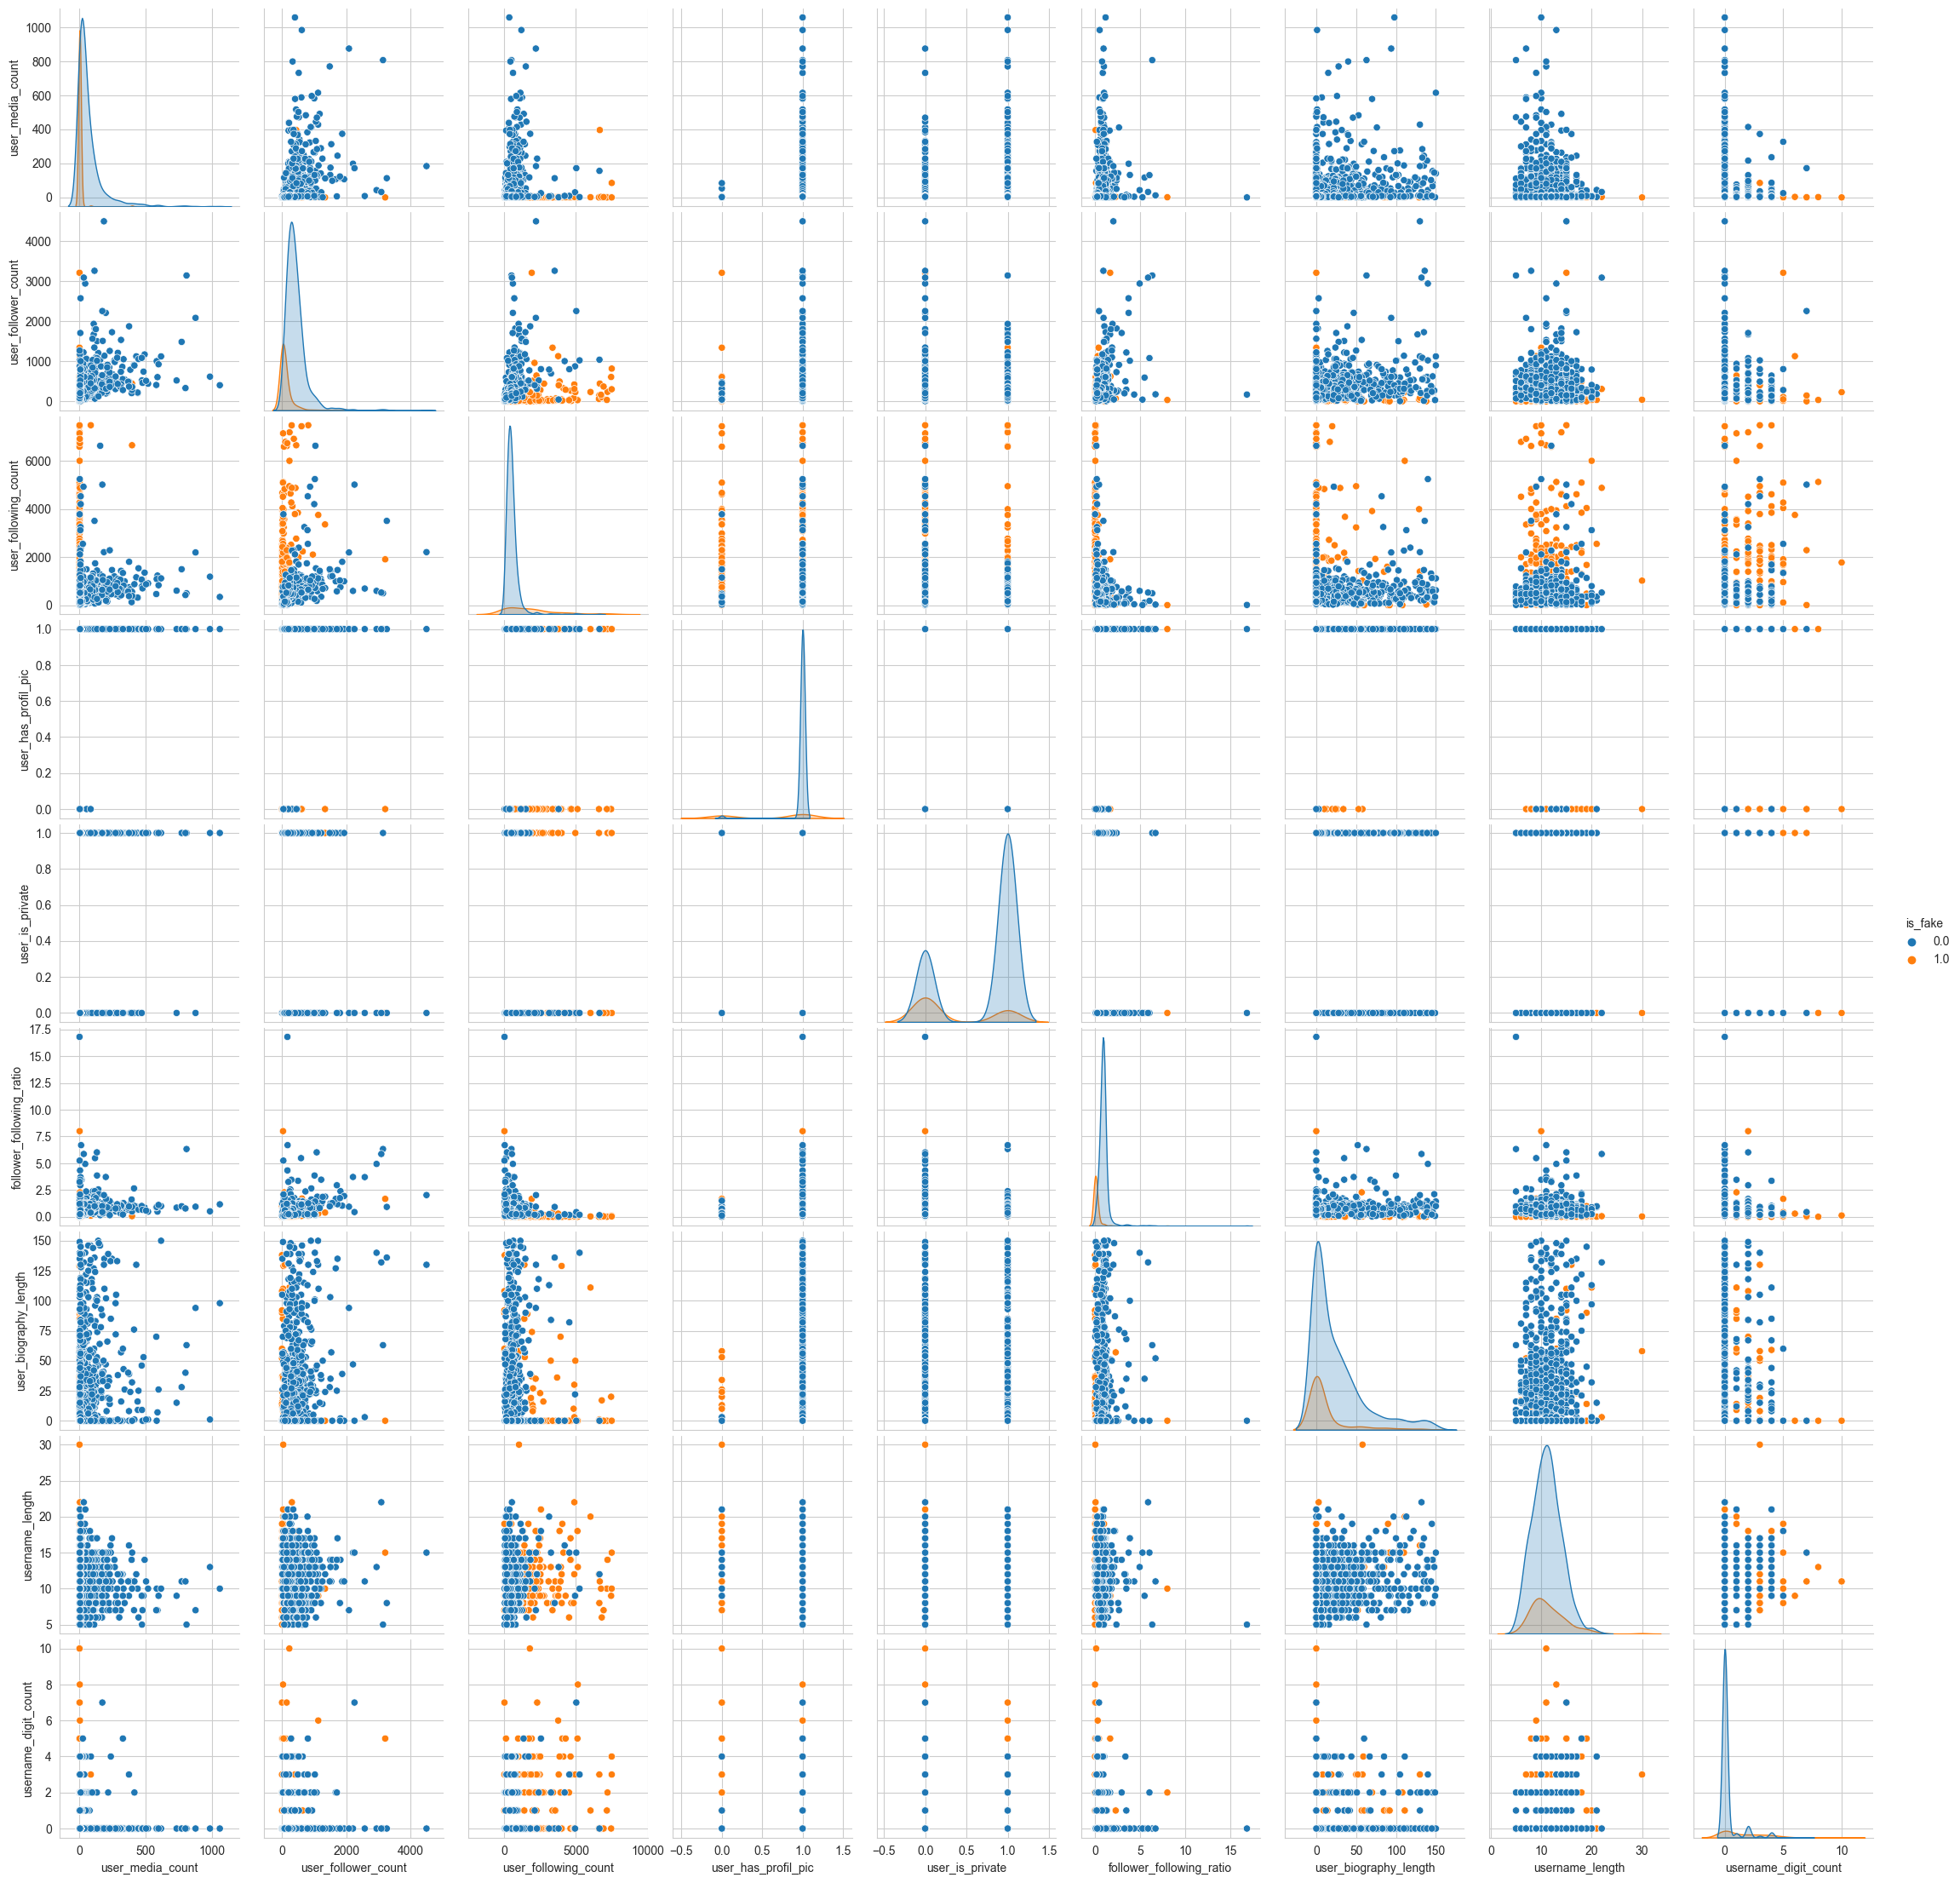

In [11]:
fake_dataset.info()
sns.pairplot(fake_dataset, hue = 'is_fake')

In [4]:
fake_dataset.describe()

,user_media_count,user_follower_count,user_following_count,user_has_profil_pic,user_is_private,follower_following_ratio,user_biography_length,username_length,username_digit_count,is_fake
count,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000,1194.000000
mean,57.596315,369.095477,744.261307,0.922948,0.657454,0.812195,22.847571,11.123953,0.495812,0.167504
std,107.402157,372.775741,1032.526420,0.266786,0.474760,0.804559,33.492868,2.998135,1.212010,0.373582
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,3.000000,152.000000,267.000000,1.000000,0.000000,0.481885,0.000000,9.000000,0.000000,0.000000
50%,20.000000,304.000000,449.000000,1.000000,1.000000,0.839351,7.000000,11.000000,0.000000,0.000000
75%,67.000000,481.000000,711.000000,1.000000,1.000000,1.003664,33.000000,13.000000,0.000000,0.000000
max,1058.000000,4492.000000,7497.000000,1.000000,1.000000,16.800000,150.000000,30.000000,10.000000,1.000000


In [13]:
X = fake_dataset.drop('is_fake', axis=1)
y = fake_dataset.is_fake

# Convert y to {-1, 1}
# "1" is real account and "-1" is fake account
y = (y * 2) - 1
print(y)

def train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) 
    o = np.random.permutation(X.shape[0])
    
    X_train, X_test = np.split(np.take(X,o,axis=0), [i])
    y_train, y_test = np.split(np.take(y,o), [i])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1189   -1.0
1190   -1.0
1191   -1.0
1192   -1.0
1193   -1.0
Name: is_fake, Length: 1194, dtype: float64


d:\Games\Miniconda\lib\site-packages\numpy\lib\shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


In [6]:
class Linear(object):
    def __call__(self, x, y):
        return np.dot(x, y.T)

    def __repr__(self):
        return "Linear kernel"


class Poly(object):
    def __init__(self, degree=2):
        self.degree = degree

    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree

    def __repr__(self):
        return "Poly kernel"


class RBF(object):
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        x = np.atleast_2d(x)
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(x, y) ** 2).flatten()

    def __repr__(self):
        return "RBF kernel"
    
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()


np.random.seed(9999)
class SVM(BaseEstimator):
    def __init__(self, C=1.0, kernel=None, tol=1e-3, max_iter=100):
        """Support vector machines implementation using simplified SMO optimization.

        Parameters
        ----------
        C : float, default 1.0
        kernel : Kernel object
        tol : float , default 1e-3
        max_iter : int, default 100
        """
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        if kernel is None:
            self.kernel = Linear()
        else:
            self.kernel = kernel

        self.b = 0
        self.alpha = None
        self.K = None

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            self.K[:, i] = self.kernel(self.X, self.X[i, :])
        self.alpha = np.zeros(self.n_samples)
        self.sv_idx = np.arange(0, self.n_samples)
        return self._train()

    def _train(self):
        iters = 0
        while iters < self.max_iter:
            iters += 1
            alpha_prev = np.copy(self.alpha)

            for j in range(self.n_samples):
                # Pick random i
                i = self.random_index(j)

                eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                if eta >= 0:
                    continue
                L, H = self._find_bounds(i, j)

                # Error for current examples
                e_i, e_j = self._error(i), self._error(j)

                # Save old alphas
                alpha_io, alpha_jo = self.alpha[i], self.alpha[j]

                # Update alpha
                self.alpha[j] -= (self.y[j] * (e_i - e_j)) / eta
                self.alpha[j] = self.clip(self.alpha[j], H, L)

                self.alpha[i] = self.alpha[i] + self.y[i] * self.y[j] * (alpha_jo - self.alpha[j])

                # Find intercept
                b1 = (
                    self.b - e_i - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, i]
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[i, j]
                )
                b2 = (
                    self.b - e_j - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[j, j]
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, j]
                )
                if 0 < self.alpha[i] < self.C:
                    self.b = b1
                elif 0 < self.alpha[j] < self.C:
                    self.b = b2
                else:
                    self.b = 0.5 * (b1 + b2)

            # Check convergence
            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break
        logging.info("Convergence has reached after %s." % iters)

        # Save support vectors index
        self.sv_idx = np.where(self.alpha > 0)[0]

    def _predict(self, X=None):
        n = X.shape[0]
        result = np.zeros(n)
        for i in range(n):
            result[i] = np.sign(self._predict_row(X[i, :]))
        return result

    def _predict_row(self, X):
        k_v = self.kernel(self.X[self.sv_idx], X)
        return np.dot((self.alpha[self.sv_idx] * self.y[self.sv_idx]).T, k_v.T) + self.b

    def clip(self, alpha, H, L):
        if alpha > H:
            alpha = H
        if alpha < L:
            alpha = L
        return alpha

    def _error(self, i):
        """Error for single example."""
        return self._predict_row(self.X[i]) - self.y[i]

    def _find_bounds(self, i, j):
        """Find L and H such that L <= alpha <= H.
        Also, alpha must satisfy the constraint 0 <= αlpha <= C.
        """
        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C - self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        return L, H

    def random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, self.n_samples - 1)
        return i
    
def unhot(function):
    """Convert one-hot representation into one column."""

    def wrapper(actual, predicted):
        if len(actual.shape) > 1 and actual.shape[1] > 1:
            actual = actual.argmax(axis=1)
        if len(predicted.shape) > 1 and predicted.shape[1] > 1:
            predicted = predicted.argmax(axis=1)
        return function(actual, predicted)

    return wrapper

@unhot
def classification_error(actual, predicted):
    return (actual != predicted).sum() / float(actual.shape[0])


@unhot
def accuracy(actual, predicted):
    return 1.0 - classification_error(actual, predicted)

In [7]:
for kernel in [RBF(gamma=0.1), Linear()]:
    model = SVM(max_iter=500, kernel=kernel, C=0.5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Classification accuracy (%s): %s" % (kernel, accuracy(y_test, predictions)))


INFO:root:Convergence has reached after 20.


Classification accuracy (RBF kernel): 0.7907949790794979


INFO:root:Convergence has reached after 1.


Classification accuracy (Linear kernel): 0.8619246861924686


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
scaler = StandardScaler()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 2.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', nam

Text(0, 0.5, 'Second Principal Component')

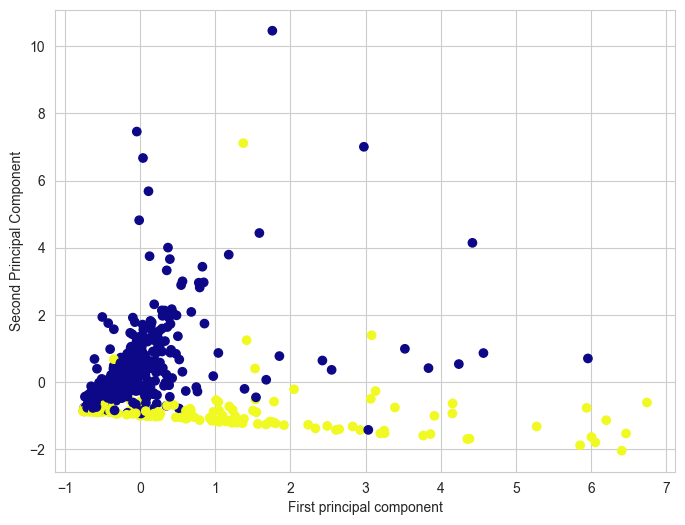

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [10]:
for kernel in [RBF(gamma=0.1), Linear()]:
    model = SVM(max_iter=500, kernel=kernel, C=0.5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Classification accuracy (%s): %s" % (kernel, accuracy(y_test, predictions)))


INFO:root:Convergence has reached after 45.


Classification accuracy (RBF kernel): 0.9372384937238494


INFO:root:Convergence has reached after 53.


Classification accuracy (Linear kernel): 0.9539748953974896


## PCA Without Library

C:\Users\Waffiq Aziz\AppData\Local\Temp\ipykernel_14124\4269968317.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = fake_dataset.drop("is_fake", 1)
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001E036EBAD30>


Text(0.5, 1.0, 'Correlation matrix')

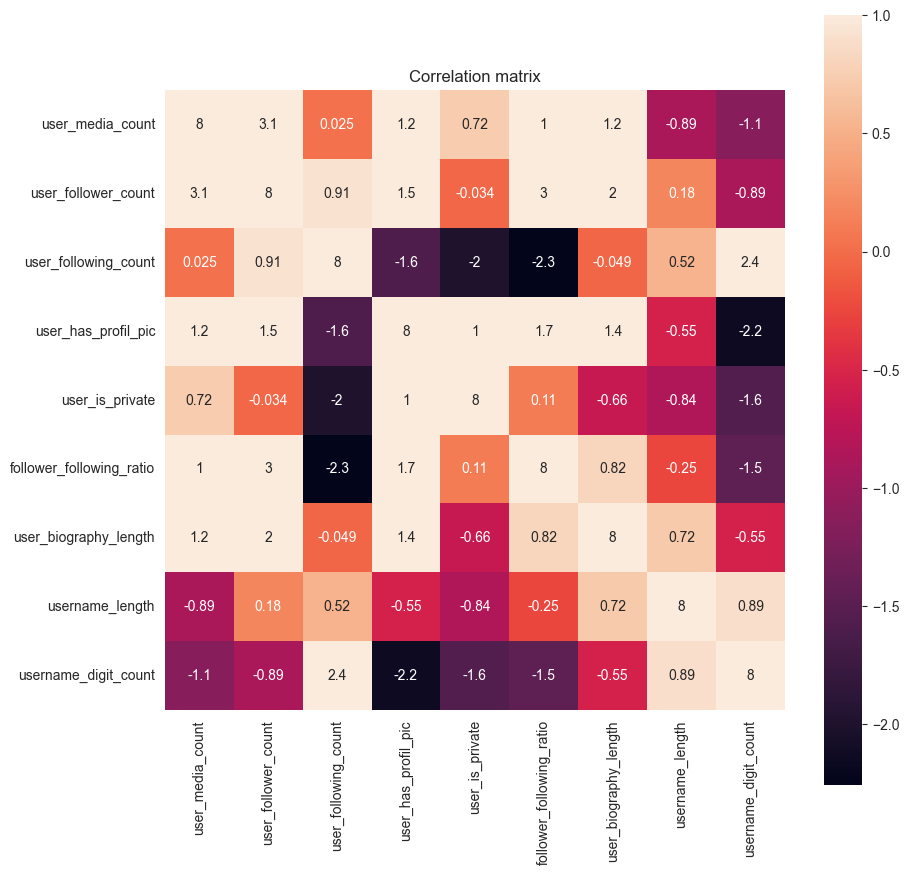

In [27]:
# We're seperating the species column
is_fake = fake_dataset["is_fake"].tolist()
X = fake_dataset.drop("is_fake", 1)

# Standardize the data
X = (X - X.mean()) / X.std(ddof=0)

# Calculating the correlation matrix of the data
X_corr = (1 / 150) * X.T.dot(X)

# Plotting the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(X_corr, vmax=1, square=True,annot=True)
plt.title('Correlation matrix')

Extract the eign values and their respective eigen vectors. ( It's important to have the sorted list of eigen values / eigen vectors) .

In [39]:
# method1
u,s,v = np.linalg.svd(X_corr)
eig_values, eig_vectors = s, u
eig_values, eig_vectors

(array([16.85956408, 12.03828661,  8.69401925,  7.30990553,  6.92046011,
         5.82718044,  5.7233439 ,  5.05595845,  3.21128164]),
 array([[-0.35276542,  0.2713193 , -0.48531677,  0.1360234 , -0.21456201,
          0.11906215,  0.22534516,  0.61508032,  0.24205531],
        [-0.39177679,  0.47975096, -0.13661533, -0.15671628, -0.24157172,
         -0.09759763, -0.0476754 , -0.30548795, -0.64003765],
        [ 0.30389433,  0.48666069, -0.33549677,  0.12619548,  0.03473447,
         -0.38422831, -0.03457001, -0.41756278,  0.46683464],
        [-0.41667034, -0.06070459,  0.13616224,  0.24374273,  0.32770274,
         -0.6155256 , -0.45065649,  0.23504301,  0.01236009],
        [-0.21312327, -0.4230951 , -0.23513286,  0.36783537, -0.5371611 ,
          0.14481197, -0.37757537, -0.33559485,  0.14240459],
        [-0.42289991,  0.07112003,  0.26488841, -0.65065136, -0.11304763,
          0.08172826, -0.13758446, -0.12939082,  0.51715936],
        [-0.2379631 ,  0.37307111,  0.28853201,  

In [38]:
# method2
np.linalg.eig(X_corr)   

(array([16.85956408, 12.03828661,  3.21128164,  8.69401925,  7.30990553,
         6.92046011,  5.05595845,  5.7233439 ,  5.82718044]),
 array([[-0.35276542, -0.2713193 ,  0.24205531, -0.48531677,  0.1360234 ,
          0.21456201, -0.61508032, -0.22534516,  0.11906215],
        [-0.39177679, -0.47975096, -0.64003765, -0.13661533, -0.15671628,
          0.24157172,  0.30548795,  0.0476754 , -0.09759763],
        [ 0.30389433, -0.48666069,  0.46683464, -0.33549677,  0.12619548,
         -0.03473447,  0.41756278,  0.03457001, -0.38422831],
        [-0.41667034,  0.06070459,  0.01236009,  0.13616224,  0.24374273,
         -0.32770274, -0.23504301,  0.45065649, -0.6155256 ],
        [-0.21312327,  0.4230951 ,  0.14240459, -0.23513286,  0.36783537,
          0.5371611 ,  0.33559485,  0.37757537,  0.14481197],
        [-0.42289991, -0.07112003,  0.51715936,  0.26488841, -0.65065136,
          0.11304763,  0.12939082,  0.13758446,  0.08172826],
        [-0.2379631 , -0.37307111,  0.1193764 ,  

In [29]:
np.sum(eig_values)

71.64000000000003

Text(0.5, 0, 'Dimensions')

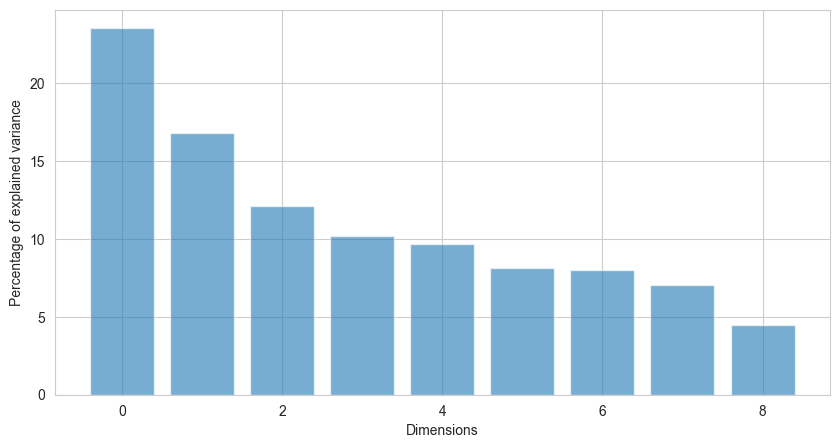

In [37]:
# plotting the variance explained by each PC 
explained_variance=(eig_values / np.sum(eig_values))*100
plt.figure(figsize=(10,5))
plt.bar(range(9), explained_variance, alpha=0.6)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Dimensions')

In [40]:
# calculating our new axis
pc1 = X.dot(eig_vectors[:,0])
pc2 = X.dot(eig_vectors[:,1])
pc3 = X.dot(eig_vectors[:,2])
pc4 = X.dot(eig_vectors[:,3])

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 2.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Games\\Miniconda\\lib\\site

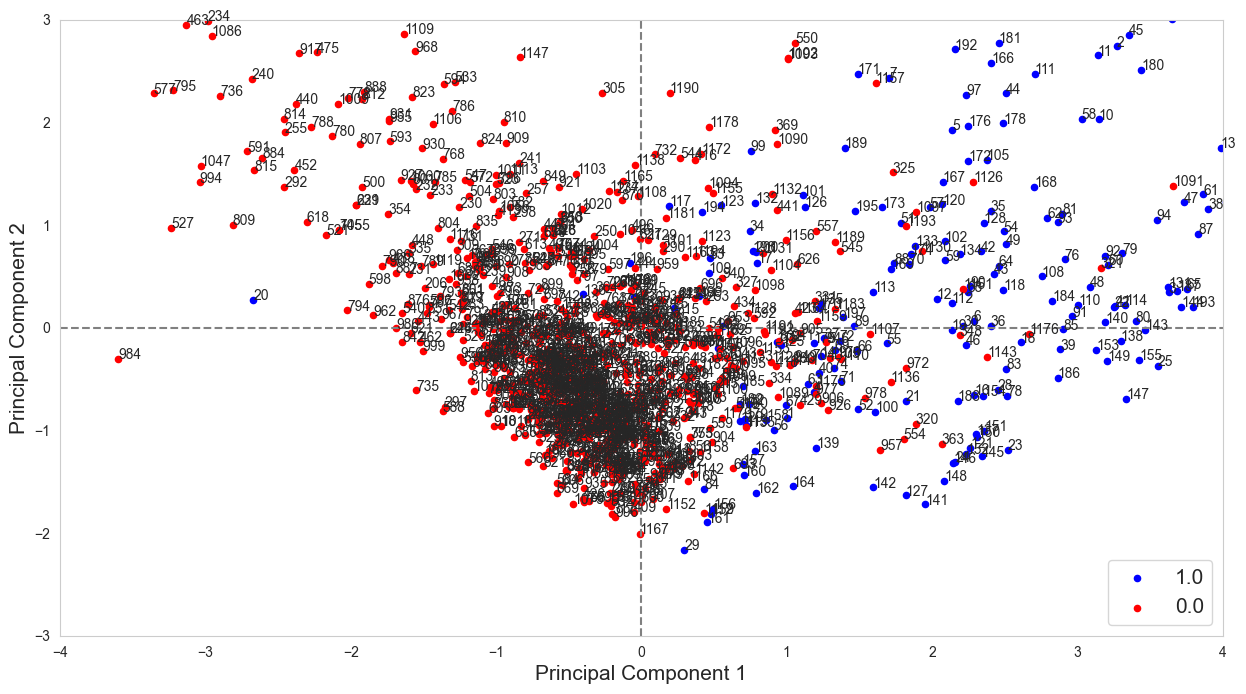

In [41]:
# plotting in 2D
def plot_scatter(pc1, pc2):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    species_unique = list(set(species))
    species_colors = ["r","b","g"]
    
    for i, spec in enumerate(species):
        plt.scatter(pc1[i], pc2[i], label = spec, s = 20, c=species_colors[species_unique.index(spec)])
        ax.annotate(str(i+1), (pc1[i],pc2[i]))
    
    from collections import OrderedDict
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 15}, loc=4)
    
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.axhline(y=0, color="grey", linestyle="--")
    ax.axvline(x=0, color="grey", linestyle="--")
    
    plt.grid()
    plt.axis([-4, 4, -3, 3])
    plt.show()
    
plot_scatter(pc1, pc2)

In [43]:
import plotly.express as px

pcs = pd.DataFrame(list(zip(pc1, pc2, pc3, is_fake)),columns =['pc1', 'pc2', 'pc3', 'is_fake']) 
fig = px.scatter_3d(pcs, x='pc1', y='pc2', z='pc3',color='is_fake')
fig.show()